# Notebook 2: Manipulating Assets

This notebook you will program the robot to spell out your initials!. You will have to specify the start and goal poses of the gripper such that the letters in your initials are grasped and placed appropriately. You will also have to write a Jacobian-based velocity controller and connect it to the `HardwareStation` in your simulation diagram.


**Learning Objectives:**
1. Perform the necessary spatial algebra for designing grasp and placement poses
2. Use Differential IK to write a gripper controller
3. Understand the diagram structure for an actively controlled IIWA wrapped in a `HardwareStation`

**What you'll build:** A simulation of the IIWA manipulating your initials such that they get placed in front of the robot. 

**Reference:** The structure is quite similar to the pick and place demo in [chapter 3](https://deepnote.com/workspace/Manipulation-ac8201a1-470a-4c77-afd0-2cc45bc229ff/project/65aad364-ef1c-45f5-a796-fac7c122e274/notebook/pick-d0b41e97e5124292af7ed01072ecece4) of Robotic Manipulation. <u> Take a moment to make sure that notebook makes sense to you.</u>

Let's start by getting our imports out of the way and launching Meshcat. 

In [ ]:
from pathlib import Path

import mpld3
import numpy as np
from matplotlib import pyplot as plt
from pydrake.all import (
    AddFrameTriadIllustration,
    AddMultibodyPlantSceneGraph,
    AngleAxis,
    DiagramBuilder,
    Integrator,
    JacobianWrtVariable,
    LeafSystem,
    MeshcatVisualizer,
    MultibodyPlant,
    MultibodyPositionToGeometryPose,
    Parser,
    PiecewisePolynomial,
    PiecewisePose,
    Quaternion,
    Rgba,
    RigidTransform,
    RotationMatrix,
    SceneGraph,
    Simulator,
    StartMeshcat,
    TrajectorySource,
)

from manipulation import running_as_notebook
from manipulation.exercises.grader import Grader
from manipulation.exercises.pick.test_pickplace_initials import TestPickPlacePoses
from manipulation.letter_generation import create_sdf_asset_from_letter
from manipulation.station import LoadScenario, MakeHardwareStation
from manipulation.utils import RenderDiagram

if running_as_notebook:
    mpld3.enable_notebook()

In [ ]:
# Start the visualizer.
meshcat = StartMeshcat()

# Design Grasp Pose

The grasp pose is commonly defined in the object frame so that the grasp pose ${^OX^G}$ is independent of the pose of the object. The grasp pose in the world frame can be computed by 

$${{^WX^G} = {}{^W}X^{O}} {^OX^G},$$


where $W$ stands for the world frame and $G$ denotes the grasp frame, following the convention in the textbook.


You should notice from the visualization below that the gripper frame is different from the world frame. In particular, the +y axis of the gripper frame points vertically downward, and the +z axis of the gripper points backward. This is an important observation for this exercise.

Simply commanding the gripper to the grasp pose does not ensure a collision-free path. To address this, we define a "pre-pick" pose—a nearby position with enough clearance to let the robot move into the grasp pose without collisions.

**Use the gripper and object's orientation from the image to design a grasp pose such that the gripper is 0.17 meters above the object frame.**

**Given the object pose X_WO, we will need both X_OG, the grasp pose in the object frame, and X_WG, the grasp pose in the world frame.**

**Remember that the X-axis is shown in red, Y-axis is in green, and Z-axis in blue.**

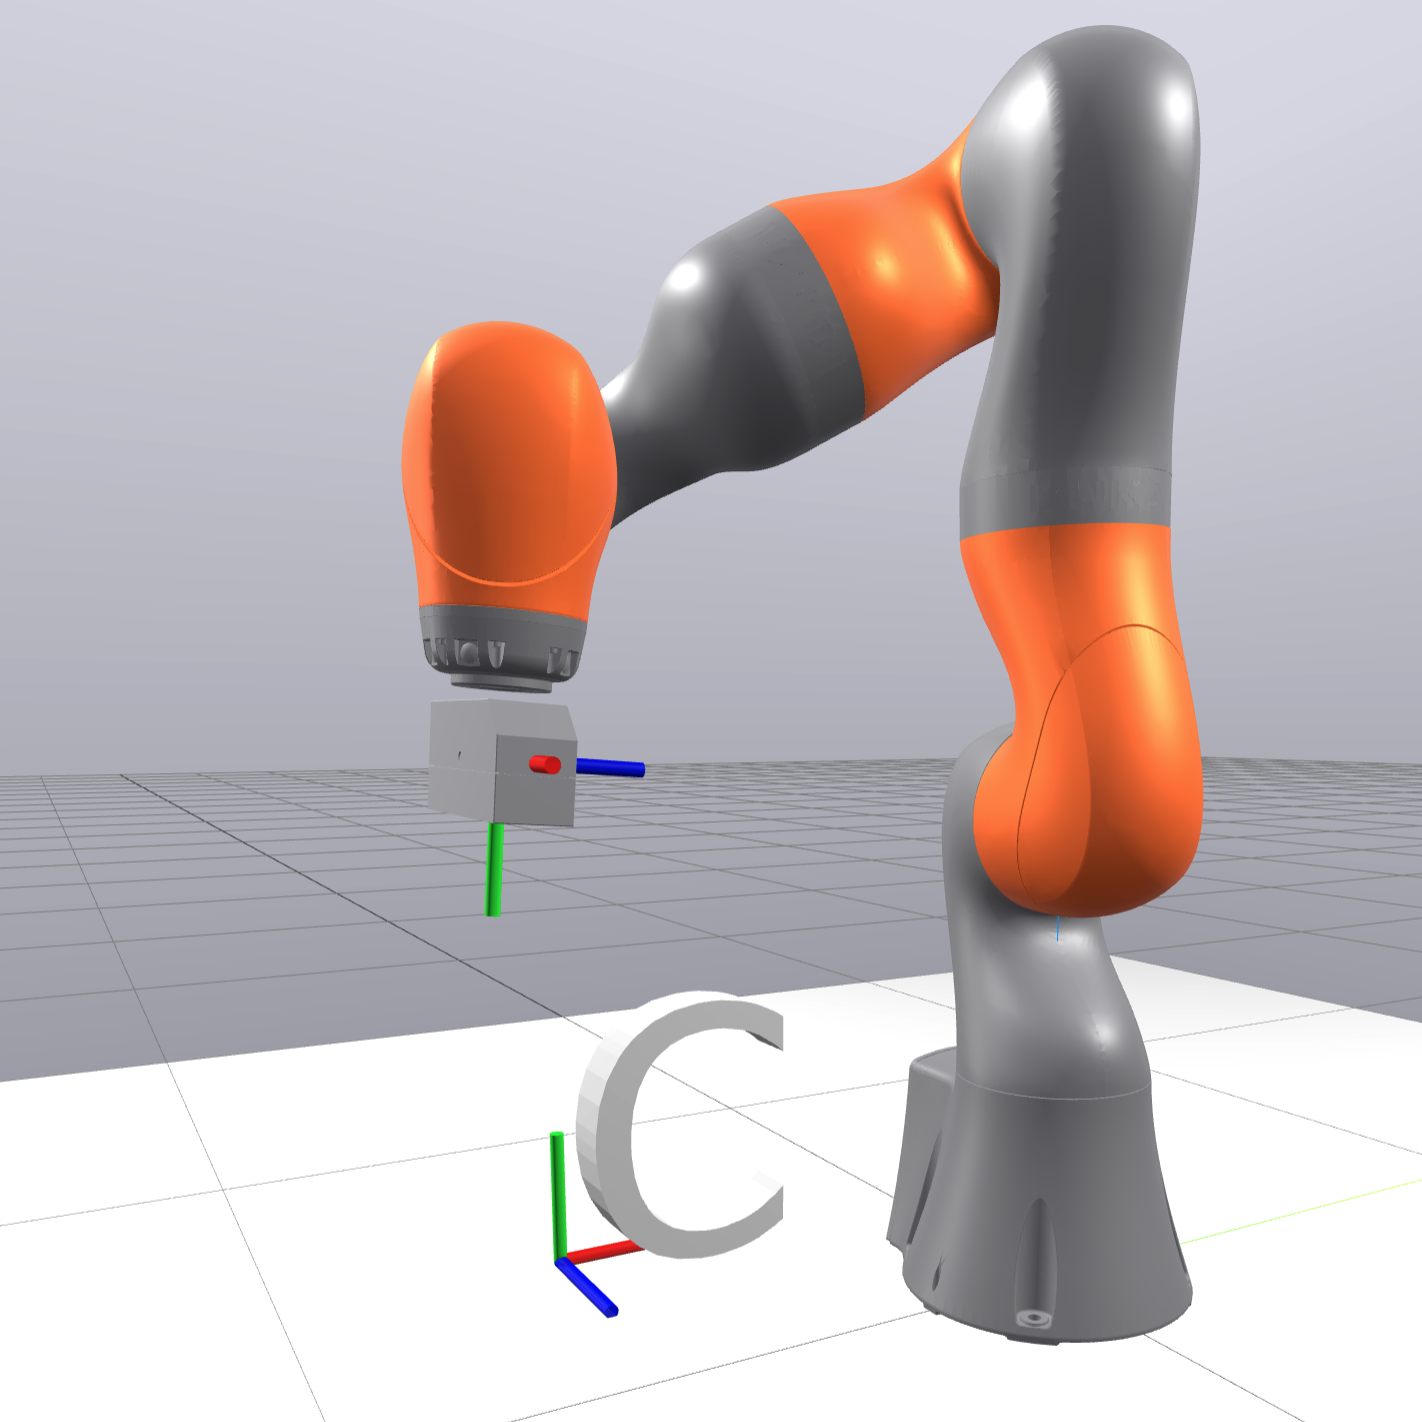

In [ ]:
def design_grasp_pose(X_WO):
    """
    fill in our code below
    """
    X_OG = RigidTransform()
    X_WG = RigidTransform()
    return X_OG, X_WG

# Design Goal Pose
We've figured out where the robot gripper needs to move given the initial pose of the objects. Now we need to decide where the gripper needs to go to place the object. 

You'll notice in the figure that the first initial ("S") is facing the right direction but is offset translationally (it is behind the robot). What we want is it to sit 0.4 meters left (-x in the world frame) of the second initial. 

The second initial ("C") is located at the right pose, but is rotated so that it is facing perpendicular to the robot. We want it to have the same orientation as the first initial. In other words, we want the second initial to have its y-axis point up in the world frame and its z-axis point along the world -y axis.

**Write a function that takes the pose of your first initial and second initial and computes corrected poses for each. Then, given the grasp pose, find the correct gripper poses in the world frame to achieve these poses.**

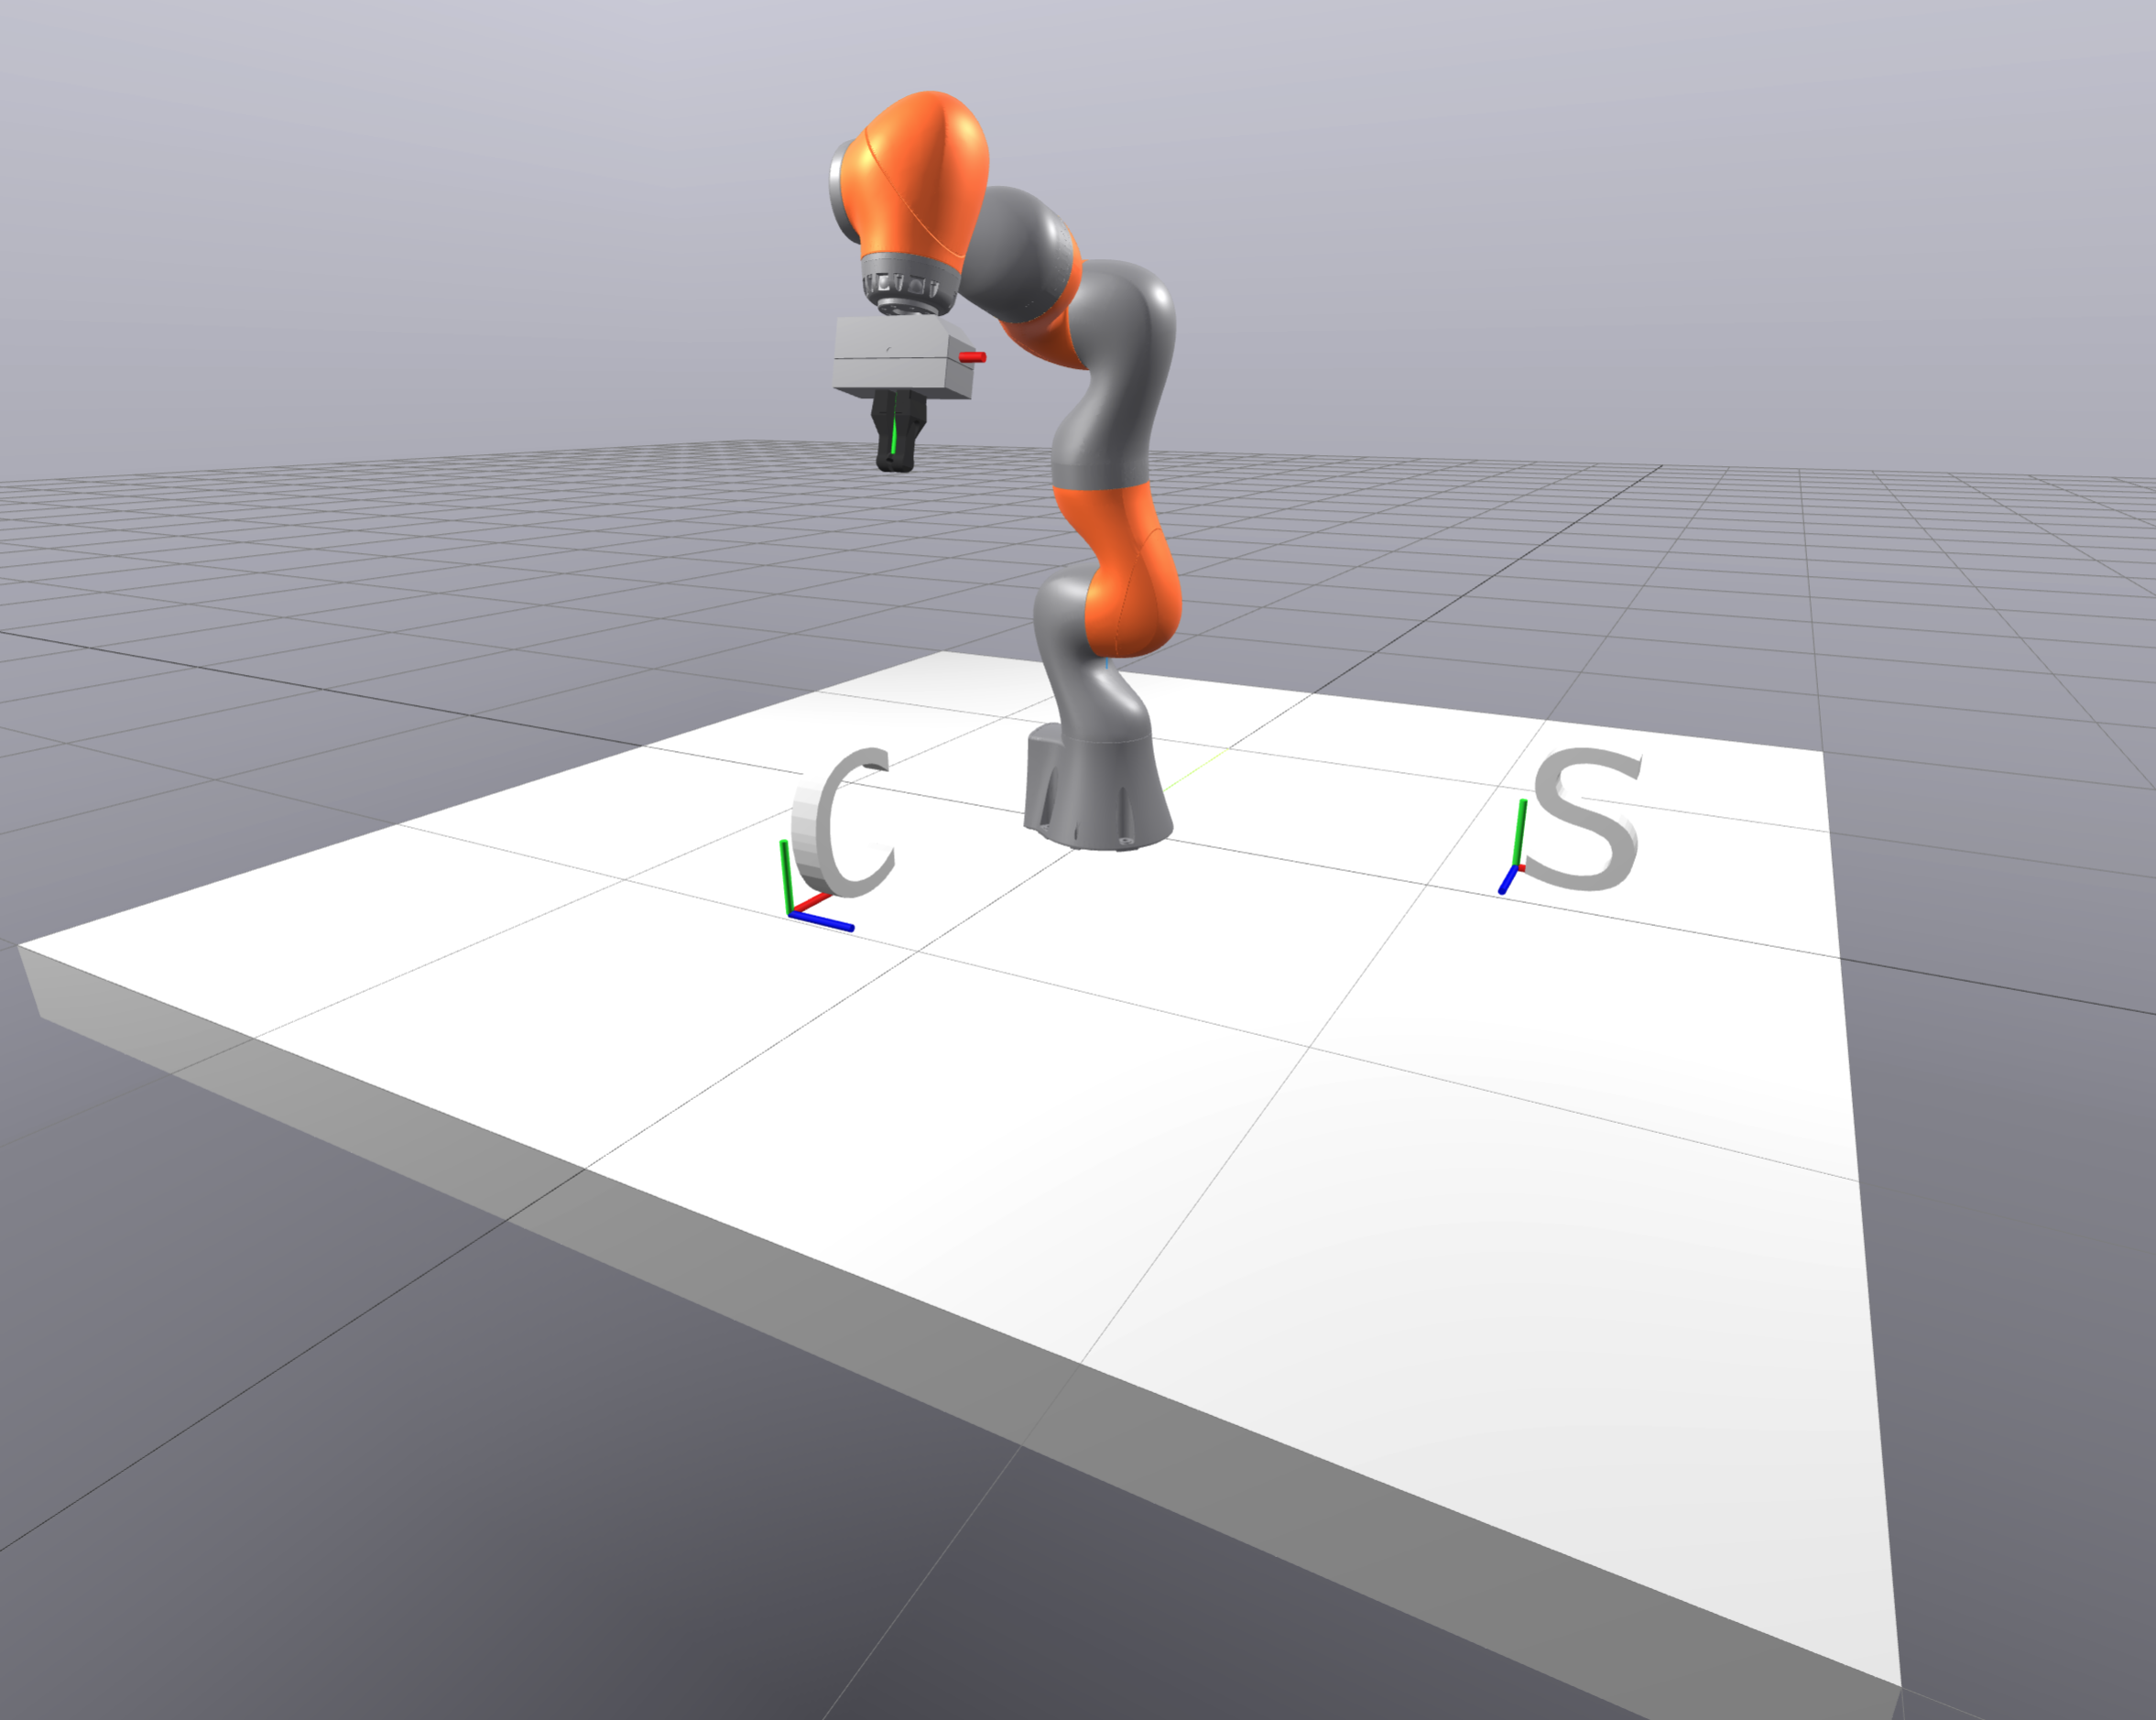

In [ ]:
def design_goal_poses(X_WO1, X_WO2, X_OG):
    """
    fill in our code below
    """
    X_WG1goal = RigidTransform()
    X_WG2goal = RigidTransform()
    return X_WG1goal, X_WG2goal

# Design Approach Pose

For both the pick and place poses, the gripper has to move close to the letters that are on the table. If it approaches those letters from the side, or if it moves one letter too close to the other, then the collision risks knocking over one of the two letters. To deal with this, we usually define "pre-pick" and "pre-place" poses for the gripper to go to. These poses have the property that the robot can achieve them without risking collision, and that the robot can move to the next pose in the trajectory without unwanted collisions. 

**Write a function that takes a gripper pose X_WG and returns an approach pose X_WGApproach. This frame will have a height of 0.1 when measured from frame G.**

In [ ]:
def approach_pose(X_WG):
    """
    fill in our code below
    """
    X_WGApproach = RigidTransform()
    return X_WGApproach

# From Keyframes to a Trajectory

Great! So to manipulate the two initials the robot is going to follow this trajectory
- Start at its default configuration (gripper opened)
- Move to the first prepick pose (gripper opened)
- Move to the grasp pose (gripper opened)
- Remain at the grasp pose (gripper closed)
- move to the default configuration (gripper closed)
- move to the first place pose (gripper closed)
- remain at the first place pose (gripper opened)
- return to the default configuration and repeat the process for the second initial


We've already solved for all of these poses! The next steps are to turn them into a valid trajectory we can command the robot to follow. 

**Your job is to implement the `MakeTrajectory` function.** It will take as input 
- a list of gripper poses of length L
- an 1xL numpy array of gripper states (distance between the two fingers)
- a list of timestamps of length L

It should return
- the **velocities** corresponding to the Piecewise trajectory defined in terms of gripper poses (of type `Trajectory`)
- a trajectory defining the state of the fingers.

In [ ]:
def MakeTrajectory(X_Gs, finger_values, sample_times):
    robot_velocity_trajectory = None
    traj_wsg_command = None
    # TODO: define a PiecewisePose out of the X_Gs

    # TODO: set robot_velocity_trajectory to the derivative of the position trajectory you just defined

    # TODO: set traj_wsg_command to a PiecewisePolynomial that commands the fingers

    return robot_velocity_trajectory, traj_wsg_command

# Initializing our System

Let's spin up a system with all of our assets. First, we'll generate the asset files for our first and last initial as well as the table. Then, we define a DMD YAML file. Just like problem set 1! 
**Be sure to fill in your (2) initials!**

In [ ]:
initials = None

In [ ]:
output_dir = Path("assets/")
for letter in initials:
    create_sdf_asset_from_letter(
        text=letter,
        font_name="DejaVu Sans",
        letter_height_meters=0.2,
        extrusion_depth_meters=0.04,
        output_dir=output_dir / f"{letter}_model",
        use_coacd=False,
        mass=0.1,
    )
letter_sdfs = [
    f"{Path.cwd()}/assets/{letter}_model/{letter}.sdf" for letter in initials
]

table_sdf = """<?xml version="1.0"?>
<sdf version="1.7">
  <model name="table">
    <pose>0 0 0 0 0 0</pose>
    <link name="table_link">
      <inertial>
        <mass>20</mass>
        <inertia>
          <ixx>1.0</ixx>
          <ixy>0.0</ixy>
          <ixz>0.0</ixz>
          <iyy>1.0</iyy>
          <iyz>0.0</iyz>
          <izz>1.0</izz>
        </inertia>
      </inertial>
      <collision name="box_collision">
        <geometry>
          <box>
            <size>2 2 0.1</size>
          </box>
        </geometry>
      </collision>
      <visual name="box_visual">
        <geometry>
          <box>
            <size>2 2 0.1</size>
          </box>
        </geometry>
      </visual>
    </link>
  </model>
</sdf>
"""

table_sdf_path = "assets/table.sdf"
with open(table_sdf_path, "w") as f:
    f.write(table_sdf)

table_sdf = f"{Path.cwd()}/assets/table.sdf"
scenario_yaml = f"""directives:
- add_model:
    name: iiwa
    file: package://drake_models/iiwa_description/sdf/iiwa7_no_collision.sdf
    default_joint_positions:
        iiwa_joint_1: [-1.57]
        iiwa_joint_2: [0.1]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-1.2]
        iiwa_joint_5: [0]
        iiwa_joint_6: [ 1.6]
        iiwa_joint_7: [0]
- add_weld:
    parent: world
    child: iiwa::iiwa_link_0
- add_model:
    name: wsg
    file: package://manipulation/hydro/schunk_wsg_50_with_tip.sdf
- add_weld:
    parent: iiwa::iiwa_link_7
    child: wsg::body
    X_PC:
        translation: [0, 0, 0.09]
        rotation: !Rpy {{ deg: [90, 0, 90]}}
- add_model:
    name: table
    file: file://{table_sdf}
- add_weld:
    parent: world
    child: table::table_link
    X_PC:
        translation: [0.0, 0.0, -0.05]
        rotation: !Rpy {{ deg: [0, 0, -90] }}
- add_model:
    name: first_initial
    file: file://{letter_sdfs[0]}
    default_free_body_pose:
        {initials[0]}_body_link:
            translation: [0.5, -0.2, 0.01]
            rotation: !Rpy {{ deg: [90, 0, 0] }}
- add_model:
    name: last_initial
    file: file://{letter_sdfs[1]}
    default_free_body_pose:
        {initials[1]}_body_link:
            translation: [-0.2, -0.5, 0.01]
            rotation: !Rpy {{ deg: [90, 0, 90] }}

model_drivers:
    iiwa: !IiwaDriver
      control_mode: position_only
      hand_model_name: wsg
    wsg: !SchunkWsgDriver {{}}
"""

# load scenario
with open("scenario.yaml", "w") as f:
    f.write(scenario_yaml)
scenario = LoadScenario(filename="scenario.yaml")

# Choice of Frames Impacts the Problem Statement!

In the above figures, notice that the coordinate frames are not actually placed at the center of the letters. Instead they are placed at their bottom-left corners. Defining grasp poses relative to these origins are tricky, because we want the robot gripper to be centered above the letter, but the letter-width varies with different initials. In the below function, let `S` describe the object frame as it is used in the SDF file corresponding to the geometry of the letter. Let `O` describe a frame placed at the center of mass of the object. The pick and place poses we defined above have frame `O` in mind, so let's make sure that that is the frame we are using. 

In [ ]:
# Helper function to express mesh poses in terms of COM rather than geometric center


def get_initial_pose(plant, body_name, plant_context):
    body = plant.GetBodyByName(body_name)
    X_WS = plant.EvalBodyPoseInWorld(plant_context, body)
    X_SO = RigidTransform(body.default_spatial_inertia().get_com())
    return X_WS @ X_SO

# A Jacobian Based Velocity Controller
Ok, we've specified the geometry of the scene, and our desired robot trajectory. Now we have to add the logic to relate our desired gripper velocities to robot joint velocities that we can command. 

**Your job is to implement the CalcOutput function. Recall that this takes the current context and sets a value for `output` based on this context.**

In [ ]:
class PseudoInverseController(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("iiwa")
        self._G = plant.GetBodyByName("body").body_frame()
        self._W = plant.world_frame()

        self.V_G_port = self.DeclareVectorInputPort("V_WG", 6)
        self.q_port = self.DeclareVectorInputPort("iiwa.position", 7)
        self.DeclareVectorOutputPort("iiwa.velocity", 7, self.CalcOutput)
        self.iiwa_start = plant.GetJointByName("iiwa_joint_1").velocity_start()
        self.iiwa_end = plant.GetJointByName("iiwa_joint_7").velocity_start()

    def CalcOutput(self, context, output):
        """
        fill in our code below.
        """
        # evaluate the V_G_port and q_port on the current context to get those values.

        # update the positions of the internal _plant_context according to `q`.
        # HINT: you can write to a plant context by calling `self._plant.SetPositions`

        # Compute the gripper jacobian
        # HINT: the jacobian is 6 x N, with N being the number of DOFs.
        # We only want the 6 x 7 submatrix corresponding to the IIWA

        # compute `v` by mapping the gripper velocity (from the V_G_port) to the joint space
        v = None
        output.SetFromVector(v)

# Putting everything together

We're almost done! Let's use the scenario we defined to initialize a diagram, and specify the keyframes as well!

We've added all the systems needed for the diagram to the builder. **Your job will be to connect all the necessary input and output ports for simulation.**

In [ ]:
# Define the builder we will use to specify the full diagram.
# Add the hardware station to the diagram
builder = DiagramBuilder()
station = MakeHardwareStation(scenario, meshcat=meshcat)
builder.AddSystem(station)
plant = station.GetSubsystemByName("plant")

# get initial poses of gripper and objects
temp_context = station.CreateDefaultContext()
temp_plant_context = plant.GetMyContextFromRoot(temp_context)
X_WGinitial = plant.EvalBodyPoseInWorld(temp_plant_context, plant.GetBodyByName("body"))
X_WO1initial = get_initial_pose(plant, f"{initials[0]}_body_link", temp_plant_context)
X_WO2initial = get_initial_pose(plant, f"{initials[1]}_body_link", temp_plant_context)

# Build trajectory keyframes
X_OG, X_WG2pick = design_grasp_pose(X_WO2initial)
_, X_WG1pick = design_grasp_pose(X_WO1initial)
X_WG1prepick, X_WG2prepick = approach_pose(X_WG1pick), approach_pose(X_WG2pick)
X_WG1goal, X_WG2goal = design_goal_poses(X_WO1initial, X_WO2initial, X_OG)
X_WG1pregoal, X_WG2pregoal = approach_pose(X_WG1goal), approach_pose(X_WG2goal)


# constants for finger distances when the gripper is opened or closed
opened = 0.107
closed = 0.0

# list of keyframes, formatted as (gripper poses, finger states)
# for each object the robot starts in its default pose with its gripper open
# then it goes to the prepick pose, the pick pose, closes the gripper, and then goes
# to the place pose
keyframes = [
    (X_WGinitial, opened),
    (X_WG2prepick, opened),
    (X_WG2pick, opened),
    (X_WG2pick, closed),
    (X_WGinitial, closed),
    (X_WG2pregoal, closed),
    (X_WG2goal, closed),
    (X_WG2goal, closed),
    (X_WG2goal, opened),
    (X_WGinitial, opened),
    (X_WG1prepick, opened),
    (X_WG1pick, opened),
    (X_WG1pick, closed),
    (X_WGinitial, closed),
    (X_WG1pregoal, closed),
    (X_WG1goal, closed),
    (X_WG1goal, opened),
    (X_WGinitial, opened),
]

# unpack the keyframes and use them to build `Trajectory` objects
# note: we specify each keyframe as occuring 2 seconds after the last.
gripper_poses = [keyframe[0] for keyframe in keyframes]
finger_states = np.asarray([keyframe[1] for keyframe in keyframes]).reshape(1, -1)
sample_times = [2 * i for i in range(len(gripper_poses))]
traj_V_G, traj_wsg_command = MakeTrajectory(gripper_poses, finger_states, sample_times)

# V_G_source defines a trajectory over gripper velocities. Add it to the system.
V_G_source = builder.AddSystem(TrajectorySource(traj_V_G))
# Add the DiffIK controller we just defined to the system
controller = builder.AddSystem(PseudoInverseController(plant))
# The HardwareStation expects robot commands in terms of joint angles.
# We define the `integrator` system to map from joint_velocities to joint_angles.
integrator = builder.AddSystem(Integrator(7))
# wsg_source defines a trajectory of finger positions. Add it to the system.
wsg_source = builder.AddSystem(TrajectorySource(traj_wsg_command))

# TODO: connect the joint velocity source to the pseudoinverse controller

# TODO: connect the controller to integrator to get joint angle commands

# TODO: connect the joint angles computed by the integrateor to the iiwa.position port on the manipulation station

# TODO: connect the "iiwa.position_measured" port on the station back to the relevant input port on the controller

# TODO: connect the wsg_source to the "wsg.position" input port of the station

# visualize axes (useful for debugging)
scenegraph = station.GetSubsystemByName("scene_graph")
AddFrameTriadIllustration(
    scene_graph=scenegraph,
    body=plant.GetBodyByName(f"{initials[0]}_body_link"),
    length=0.1,
)
AddFrameTriadIllustration(
    scene_graph=scenegraph,
    body=plant.GetBodyByName(f"{initials[1]}_body_link"),
    length=0.1,
)
AddFrameTriadIllustration(
    scene_graph=scenegraph, body=plant.GetBodyByName("body"), length=0.1
)

diagram = builder.Build()

In [ ]:
# Define the simulator.
simulator = Simulator(diagram)
context = simulator.get_mutable_context()
station_context = station.GetMyContextFromRoot(context)
integrator.set_integral_value(
    integrator.GetMyContextFromRoot(context),
    plant.GetPositions(
        plant.GetMyContextFromRoot(context),
        plant.GetModelInstanceByName("iiwa"),
    ),
)
diagram.ForcedPublish(context)
print(f"sanity check, simulation will run for {traj_V_G.end_time()} seconds")

# run simulation!
meshcat.StartRecording()
if running_as_notebook:
    simulator.set_target_realtime_rate(1.0)
simulator.AdvanceTo(traj_V_G.end_time())
meshcat.StopRecording()
meshcat.PublishRecording()

In [ ]:
# Use this to test your implementation if you want!
Grader.grade_output([TestPickPlacePoses], [locals()], "results.json")
Grader.print_test_results("results.json")

# Improving on computed grasp poses

Congratulations! The IIWA should now be manipulating your initials so that they sit next to each other. Now, go back to meshcat and in the top-right select "Open Controls", then "scene", then "drake", then "proximity". You will notice that the collision geometries are currently represented as bounding boxes around the letters. 

If the robot fails to grasp a letter, or if the letter seems to be slipping inside the robot's fingers, experiment with different grasp poses. Different letters may call for higher or lower grasps. 


**Once you have everything working, take a video and upload it to gradescope!**